In [ ]:
import os
import sys

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import ast
import json

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import FuncFormatter

import matplotlib.patches as patches


from utils.gcloud_utilities import *

from utils.metadata import *

from utils.preprocessing_utilities import import_operating_nodes

from matplotlib import colors as mcolors

In [2]:
year = "2023"

# Load data
bucket, nodes = import_operating_nodes(year)
endUse_nodes = pull_from_gcs_csv(
    bucket, GCLOUD_PREPROCESSED_DIR + BENCHMARK_PREPROCESSED_DIR + "endUse_nodes.csv"
)

edges = pull_from_gcs_csv(
    bucket,
    GCLOUD_PREPROCESSED_DIR
    + BENCHMARK_PREPROCESSED_DIR
    + BENCHMARK_EDGES_DIR
    + BENCHMARK_EDGES_FILE,
)

edges["properties"] = edges["properties"].astype(str).apply(ast.literal_eval)
dict_df = pd.json_normalize(edges["properties"])
edges = edges.drop(columns=["properties"]).join(dict_df)

nodes_df = pd.concat((nodes, endUse_nodes))

nodes_df["type"] = (
    nodes_df["mine_type"]
    .fillna(nodes_df["process_type"])
    .fillna(nodes_df["product_type"])
)
nodes_df["country"] = nodes_df["country"].fillna(nodes_df["region"])
nodes_df["company"] = nodes_df["company"].fillna(nodes_df["operator_short_clean"])
# nodes_df = nodes_df.dropna(subset=['type'])[['node_id', 'type', year]]

stages_dict = {
    "mining": ["Brine", "Spodumene", "Mica", "Pegmatite"],
    "carbonate": ["Lithium Carbonate"],
    "hydroxide": ["Lithium Hydroxide"],
    "cathode": [
        "NCM mid nickel",
        "LFP",
        "4V Ni or Mn based",
        "NCA",
        "NCM high nickel",
        "LCO",
        "NCM low nickel",
        "5V Mn based",
    ],
    "battery": [
        "Cylindrical",
        "Pouch",
        "Cylindrical, Pouch",
        "Pouch, Prismatic",
        "Prismatic",
        "Cylindrical, Prismatic",
        "Cylindrical, Pouch, Prismatic",
    ],
    "end_use": ["EV", "ESS", "Portable"],
}

nodes_df["stage"] = nodes_df["type"].map(
    {item: cat for cat, items in stages_dict.items() for item in items}
)

2025-05-22 11:13:02.112 | INFO     | utils.gcloud_utilities:fetch_gcs_bucket:16 - Fetching GCS bucket: lithium-datasets in project: critical-minerals'
c:\Users\bapti\OneDrive - University of Cambridge\Documents\critical-minerals\.venv\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
2025-05-22 11:13:45.187 | INFO     | utils.gcloud_utilities:pull_from_gcs_csv:27 - Pulling data from preprocessed/benchmark/benchmark_nodes.csv in bucket lithium-datasets
2025-05-22 11:13:47.742 | INFO     | utils.gcloud_utilities:pull_from_gcs_csv:27 - Pulling data from preprocessed/benchmark/endUse_nodes.csv in bucket lithium-datasets
2025-05-22 11:13:47.952

In [ ]:
unit_conversion = pull_from_gcs_excel(
    bucket, MAPPINGS_DIR + "Li_unit_conversion.xlsx", sheet_name="Sheet1"
)


converted_nodes = nodes_df.merge(
    unit_conversion[["type", "node_conversion"]],
    left_on="type",
    right_on="type",
    how="left",
)


converted_nodes[year] = converted_nodes[year] * converted_nodes["node_conversion"]

2025-05-22 11:13:49.979 | INFO     | utils.gcloud_utilities:pull_from_gcs_excel:46 - Pulling data from raw/mappings/Li_unit_conversion.xlsx in bucket lithium-datasets


In [4]:
## Import and convert units

all_trees = pd.read_csv(project_root + "/figures/main_results/upstream_trees.csv")

converted_tree = all_trees.merge(
    unit_conversion[["type", "edge_conversion"]],
    left_on="type_source",
    right_on="type",
    how="left",
)
converted_tree["adj_vol_lithium"] = (
    converted_tree["adj_vol"] * converted_tree["edge_conversion"]
)

converted_tree["stage_source"] = converted_tree["stage_source"].str.capitalize()
converted_tree = converted_tree.rename(
    columns={
        "source": "Node ID",
        "country_source": "Country",
        "stage_source": "Supply stage",
        "type_source": "Type",
        "edge_type": "Product",
        "adj_vol": "Product mass (t)",
        "adj_vol_lithium": "Lithium equivalent (t)",
    }
)

In [5]:
# Calculate total lithium content per manufacturer
manufacturer_total = (
    converted_tree.groupby("battery_node_id")["Lithium equivalent (t)"]
    .sum()
    .reset_index()
)
manufacturer_total.rename(
    columns={"Lithium equivalent (t)": "total_lithium"}, inplace=True
)

# Merge back to compute percentage contribution per node
percentage_df = converted_tree.merge(manufacturer_total, on="battery_node_id")
percentage_df["percentage"] = (
    100 * percentage_df["Lithium equivalent (t)"] / percentage_df["total_lithium"]
)

top10_df = (
    percentage_df.sort_values(["battery_node_id", "percentage"], ascending=False)
    .groupby("battery_node_id")
    .head(10)
)

important_count = (
    top10_df[["Country", "Node ID", "percentage"]]
    .groupby(["Country", "Node ID"])
    .count()
    .reset_index()
)
important_count["percentage"] = (
    important_count["percentage"] / len(converted_tree["battery_node_id"].unique())
) * 100

important_count_med = (
    top10_df[["Country", "Node ID", "percentage"]]
    .groupby(["Country", "Node ID"])
    .median()
)
important_count = important_count.merge(
    important_count_med, on=["Country", "Node ID"], suffixes=("_count", "_median")
)

In [6]:
battery_reliance = percentage_df.merge(
    nodes_df[["node_id", "name", "company", "country"]],
    left_on="battery_node_id",
    right_on="node_id",
    how="left",
    suffixes=("", "_battery"),
).rename(
    columns={
        "name": "battery_name",
        "company": "battery_company",
        "country": "battery_country",
    }
)

C:\Users\bapti\AppData\Local\Temp\ipykernel_39056\3617978886.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(all_upstream_countries))   # choose any qualitative cmap


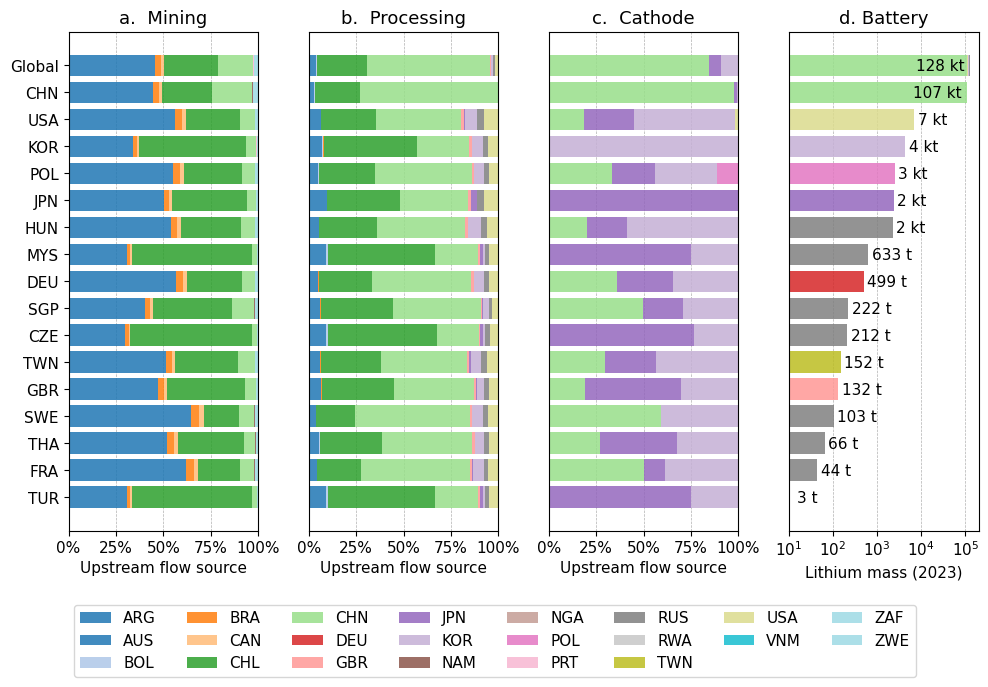

In [ ]:
fontsize = 11

# ------------------------------------------------------------------------------
# 1) Read and inspect your CSV
# ------------------------------------------------------------------------------
df = battery_reliance.copy()
df["Supply stage"] = df["Supply stage"].replace(
    {"Carbonate": "Processing", "Hydroxide": "Processing"}
)

# Define the stages in a specific order:
desired_stages = ["Mining", "Processing", "Cathode"]

# ------------------------------------------------------------------------------
# 2) Prepare a consistent color map for all upstream countries
# ------------------------------------------------------------------------------
all_upstream_countries = sorted(df["Country"].dropna().unique())
# colors = plt.cm.get_cmap('tab20', len(all_upstream_countries))
# country_to_color = {
#     country: colors(i) for i, country in enumerate(all_upstream_countries)
# }

# ## Option to import colors consistent with previous plots
# with open("color_map_temp.json", "r") as json_file:
#     country_to_color = json.load(json_file)

all_upstream_countries = sorted(df["Country"].dropna().unique())
cmap = plt.cm.get_cmap(
    "tab20", len(all_upstream_countries)
)  # choose any qualitative cmap
country_to_color = {
    country: mcolors.to_hex(
        cmap(i)
    )  # store as hex if you need JSON‐serializable strings
    for i, country in enumerate(all_upstream_countries)
}

distinct_colors = [
    "#ff00ff",  # Magenta
    "#ffd700",  # Gold
    "#008080",  # Teal
    "#4b0082",
]  # Indigo

new_countries = [i for i in all_upstream_countries if i not in country_to_color.keys()]

additional_colors = dict(zip(new_countries, distinct_colors))

country_to_color.update(additional_colors)

# ------------------------------------------------------------------------------
# 3) Create subplots: 3 columns side by side, sharey=True so the battery_country ordering aligns
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))
plt.subplots_adjust(left=0.2, wspace=0)

# We'll collect legend handles/labels for later sorting
handles_for_legend = []
labels_for_legend = []

# # ------------------------------------------------------------------------------
# # Compute total lithium from the Cathode stage for each battery country (for y-axis label modification)
# # ------------------------------------------------------------------------------
# df_cathode = df[df["Supply stage"] == "Cathode"].copy()
# cathode_totals = df_cathode.groupby("battery_country")["Lithium equivalent (t)"].sum().to_dict()

battery_vols = (
    converted_nodes[converted_nodes["stage"] == "battery"][["country", "2023"]]
    .groupby("country")
    .sum()
    .reset_index()
    .sort_values("2023", ascending=True)
)


# ------------------------------------------------------------------------------
# Helper function: pivot to get 100% row-wise distribution
# ------------------------------------------------------------------------------
def get_100pct_pivot(df_stage):
    # Group by battery_country and upstream 'Country' to sum Lithium equivalent
    grouped = (
        df_stage.groupby(["battery_country", "Country"])["Lithium equivalent (t)"]
        .sum()
        .reset_index()
    )
    pivot_abs = grouped.pivot(
        index="battery_country", columns="Country", values="Lithium equivalent (t)"
    ).fillna(0)
    # Sort battery countries alphabetically and then reverse the order (if desired)
    pivot_abs = pivot_abs.reindex(sorted(pivot_abs.index))[-1::-1]
    row_sums = pivot_abs.sum(axis=1)
    pivot_fraction = pivot_abs.div(row_sums, axis=0).fillna(0)
    return pivot_fraction, pivot_abs


# ------------------------------------------------------------------------------
# 4) Loop through the 3 stages and produce each subplot
# ------------------------------------------------------------------------------
for i, stage in enumerate(desired_stages):
    ax = axes[i]
    df_stage = df[df["Supply stage"] == stage].copy()
    if df_stage.empty:
        ax.set_title(stage, fontsize=fontsize + 2)
        continue

    pivot_frac, pivot_abs = get_100pct_pivot(df_stage)

    df_stage_global = df_stage.copy()
    df_stage_global["battery_country"] = "Global"
    pivot_frac_global, pivot_abs_global = get_100pct_pivot(df_stage_global)

    pivot_abs = pd.concat((pivot_abs, pivot_abs_global), axis=0)
    pivot_frac = pd.concat((pivot_frac, pivot_frac_global), axis=0)

    pivot_frac = pivot_frac.loc[
        list(battery_vols["country"]) + ["Global"]
    ]  # Sort according to battery production
    battery_countries = pivot_frac.index
    bottom = np.zeros(len(pivot_frac))
    y_positions = range(len(battery_countries))

    if i == 0:
        mining_frac = pivot_frac.copy()
    elif i == 1:
        processing_frac = pivot_frac.copy()
    elif i == 2:
        cathode_frac = pivot_frac.copy()

    for col in pivot_frac.columns:
        values = pivot_frac[col].values
        c = country_to_color[col]
        bars = ax.barh(
            y_positions,
            values,
            left=bottom,
            color=c,
            edgecolor="none",
            label=col,
            alpha=0.85,
        )
        bottom += values
        if col not in labels_for_legend:
            handles_for_legend.append(bars)
            labels_for_legend.append(col)

    # Set subplot title (fontsize 14)
    ax.set_title(["a. ", "b. ", "c. "][i] + " " + stage, fontsize=fontsize + 2)
    ax.set_xlim(0, 1)

    # Format x-axis tick labels as percentages (0–100%) with fontsize 12
    formatter = FuncFormatter(lambda x, pos: f"{int(x*100)}%")
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis="x", labelsize=fontsize)
    ax.grid(axis="x", which="major", linestyle="--", linewidth=0.5)
    ax.set_axisbelow(True)

    # Set y-ticks (the positions remain the same for all subplots)
    ax.set_yticks(y_positions)
    if i == 0:
        # For the leftmost subplot, update battery_country labels by appending the total Cathode volume
        new_labels = []
        for label in battery_countries:
            # total_vol = cathode_totals.get(label, 0)

            # new_labels.append(f"{label} ({total_vol:,.0f})")
            new_labels.append(f"{label}")
        ax.set_yticklabels(new_labels, fontsize=fontsize)
        # ax.set_ylabel("Battery-Manufacturer Country", fontsize=14)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])


# ------------------------------------------------------------------------------
# 5) Create the 4th subplot: Battery Volume (non-100% absolute values)
# ------------------------------------------------------------------------------
ax = axes[3]
# For consistency, order countries as in battery_vols
countries = battery_vols["country"].tolist()
values = battery_vols["2023"].tolist()
y_positions = range(len(countries))

# Create horizontal bars using the color mapped for each country
ax.barh(
    y_positions,
    values,
    color=[country_to_color.get(country, "#808080") for country in countries],
    edgecolor="none",
    alpha=0.85,
)
ax.set_xscale("log")
ax.set_xlim(1e1, 2e5)
ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
ax.grid(axis="x", which="major", linestyle="--", linewidth=0.5)
ax.set_axisbelow(True)
ax.set_yticks(y_positions)
ax.set_yticklabels(countries, fontsize=fontsize)
ax.set_title("d. Battery", fontsize=fontsize + 2)
ax.set_xlabel("Lithium mass (2023)", fontsize=fontsize)
ax.tick_params(axis="x", labelsize=fontsize)

# Annotate each bar:
for i, (country, val) in enumerate(zip(countries, values)):
    # Choose units: tonnes if <10,000, otherwise kilotonnes (kt)
    if val < 1e3:
        label = f"{round(val):,} t"
    else:
        label = f"{round(val/1000):,} kt"
    # For the top 2 rows, position the label inside (centered);
    # for the others, position it just to the right of the bar.
    if i > len(values) - 2:  # top two rows
        x_pos = val * 0.75
        ha = "right"
        text_color = "black"
    else:
        x_pos = val * 1.2 if val > 1e1 else 1.5e1  # a small offset to the right
        ha = "left"
        text_color = "black"
    ax.text(
        x_pos,
        y_positions[i] - 0.04,
        label,
        va="center",
        ha=ha,
        fontsize=fontsize,
        color=text_color,
    )

# -------------------------------------------------------------------------------
# Add a global bar as if it were another country, breaking down the colour per country:
# -------------------------------------------------------------------------------
global_total = sum(values)
global_y = len(countries)  # new row index for the global bar
cum = 0
for country, val in zip(countries[-1:1:-1], values[-1:1:-1]):
    ax.barh(
        global_y,
        val,
        left=cum,
        color=country_to_color.get(country, "#808080"),
        edgecolor="none",
        alpha=0.85,
    )
    cum += val

# Annotate the global bar with its total value
if global_total < 1e3:
    global_label = f"{round(global_total):,} t"
else:
    global_label = f"{round(global_total/1000):,} kt"
x_pos_global = global_total * 0.75
ax.text(
    x_pos_global,
    global_y - 0.04,
    global_label,
    va="center",
    ha="right",
    fontsize=fontsize,
    color="k",
)

# Update the y-ticks and labels to include the new "Global" row
new_y_positions = list(y_positions) + [global_y]
new_labels = countries + ["Global"]
ax.set_yticks([])
ax.set_yticklabels([])


# ------------------------------------------------------------------------------
# 5) Create a single legend spanning the entire figure width
#    and order it alphabetically.
# ------------------------------------------------------------------------------
legend_items = sorted(zip(labels_for_legend, handles_for_legend), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*legend_items)
axes[0].set_xlabel("Upstream flow source", fontsize=fontsize)
axes[1].set_xlabel("Upstream flow source", fontsize=fontsize)
axes[2].set_xlabel("Upstream flow source", fontsize=fontsize)

fig.legend(
    sorted_handles,
    sorted_labels,
    loc="lower center",
    ncol=8,
    bbox_to_anchor=(0.5, -0.15),
    fontsize=fontsize,
)

plt.tight_layout()
plt.show()

In [ ]:
# Save output plot
output_path = "/figures/article_figures/"
filename = "Geopolitical_risk"
fig.savefig(
    project_root + output_path + filename + ".png", bbox_inches="tight", dpi=300
)
fig.savefig(
    project_root + output_path + filename + ".eps",
    format="eps",
    bbox_inches="tight",
    dpi=300,
)
fig.savefig(
    project_root + output_path + filename + ".pdf",
    format="pdf",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [15]:
cath_sum = (
    nodes_df[(nodes_df["stage"] == "cathode")][["country", "2023"]]
    .groupby("country")
    .sum()
    .reset_index()
)
cath_sum["perc"] = cath_sum["2023"] / cath_sum["2023"].sum()
cath_sum

,country,2023,perc
0,CAN,400.0,0.000129
1,CHN,2645930.0,0.853989
2,DEU,1000.0,0.000323
3,JPN,145130.0,0.046842
4,KOR,293500.0,0.094729
5,POL,3200.0,0.001033
6,TWN,7060.0,0.002279
7,USA,1600.0,0.000516
8,VNM,500.0,0.000161


In [16]:
processing_frac[:-2].mean() * 100

Country
ARG     6.195056
AUS     0.332095
BOL     0.292722
BRA     0.195148
CHL    37.233920
CHN    41.642598
GBR     1.162333
JPN     0.738613
KOR     4.109496
RUS     2.656761
USA     5.441258
dtype: float64

In [17]:
converted_nodes[converted_nodes["stage"] == "mining"][
    ["node_id", "country", "Primary Owner Country", "2023"]
].groupby("country").sum().reset_index().sort_values("2023", ascending=False)

,country,node_id,Primary Owner Country,2023
1,AUS,1856,USAAustraliaAustraliaUSAAustraliaUSA,71836.203113
5,CHL,792,ChileUSAUSA,44150.358641
6,CHN,7523,ChinaChinaChinaChinaChinaChinaChinaChinaChinaC...,34262.579608
0,ARG,1442,USAChinaUSAUSA,8596.732386
3,BRA,967,CanadaNetherlandsBrazil,5824.089863
13,ZWE,1806,ChinaChinaChinaChinaChinaUK,3795.052104
4,CAN,444,CanadaChina,3240.824198
7,NAM,203,China,1502.990932
2,BOL,55,China,563.621600
11,USA,204,USA,563.621600


In [19]:
ownership = converted_nodes[converted_nodes["stage"] == "mining"].sort_values(
    "2023", ascending=False
)[1:][["Primary Owner Country", "2023"]]
ownership_gb_chn = converted_nodes[converted_nodes["stage"] == "mining"].sort_values(
    "2023", ascending=False
)[:1][["Primary Owner Country", "2023"]]
ownership_gb_chn["Primary Owner Country"], ownership_gb_chn["2023"] = (
    "China",
    ownership_gb_chn["2023"] * 0.51,
)
ownership_gb_usa = converted_nodes[converted_nodes["stage"] == "mining"].sort_values(
    "2023", ascending=False
)[:1][["Primary Owner Country", "2023"]]
ownership_gb_usa["Primary Owner Country"], ownership_gb_usa["2023"] = (
    "USA",
    ownership_gb_usa["2023"] * 0.49,
)
ownership = (
    pd.concat((ownership, ownership_gb_chn, ownership_gb_usa))
    .groupby("Primary Owner Country")
    .sum()
    .reset_index()
)
ownership["perc"] = ownership["2023"] / ownership["2023"].sum()
ownership

,Primary Owner Country,2023,perc
0,Australia,24423.602653,0.139409
1,Brazil,939.369333,0.005362
2,Canada,5072.594397,0.028954
3,Chile,31938.557315,0.182305
4,China,60027.601668,0.342636
5,Netherlands,2254.486399,0.012869
6,Nigeria,56.362160,0.000322
7,Portugal,375.747733,0.002145
8,Rwanda,18.787387,0.000107
9,UK,537.882880,0.003070


In [20]:
# # -------------------------------
# # 1) Prepare the data and compute metrics
# # -------------------------------
# df = battery_reliance.copy()
#
# # Ensure supply stage is standardized (e.g. processing substitutes)
# df['Supply stage'] = df['Supply stage'].replace({'Carbonate': 'Processing', 'Hydroxide': 'Processing'})
#
# df_nodes = df[['Supply stage', 'Type', 'Node ID', 'Country', 'battery_node_id', 'Lithium equivalent (t)']].groupby(['Supply stage', 'Type', 'Node ID', 'Country', 'battery_node_id']).sum().reset_index()
#
# # Mark the top 10 nodes for each battery manufacturer based on flow.
# df_nodes['rank'] = df_nodes.groupby('battery_node_id')['Lithium equivalent (t)'].rank(method='first', ascending=False)
# df_nodes['is_top10'] = df_nodes['rank'] <= 10
#
# df_nodes

In [21]:
df = battery_reliance.copy()

# Ensure supply stage is standardized (e.g. processing substitutes)
df["Supply stage"] = df["Supply stage"].replace(
    {"Carbonate": "Processing", "Hydroxide": "Processing"}
)

df_nodes = (
    df[
        [
            "Supply stage",
            "Type",
            "Node ID",
            "Country",
            "battery_node_id",
            "Lithium equivalent (t)",
        ]
    ]
    .groupby(["Supply stage", "Type", "Node ID", "Country", "battery_node_id"])
    .sum()
    .reset_index()
)

# Mark the top 10 nodes for each battery manufacturer based on flow.
df_nodes["rank"] = df_nodes.groupby("battery_node_id")["Lithium equivalent (t)"].rank(
    method="first", ascending=False
)
df_nodes["is_top10"] = df_nodes["rank"] <= 10

total_batteries = df_nodes["battery_node_id"].nunique()

# Group by Node ID, Supply stage, Type, and Country.
node_metrics = (
    df_nodes.groupby(["Node ID", "Supply stage", "Type", "Country"])
    .agg(total_flow=("Lithium equivalent (t)", "sum"), top10_count=("is_top10", "sum"))
    .reset_index()
)

node_metrics["perc_top10"] = (node_metrics["top10_count"] / total_batteries) * 100

# For the x-axis: calculate percentage of flow volume for that (Supply stage, Type).
total_flow_combined = (
    df_nodes.groupby(["Supply stage", "Type"])["Lithium equivalent (t)"]
    .sum()
    .reset_index()
)
total_flow_combined.columns = ["Supply stage", "Type", "total_flow_type"]

node_metrics = pd.merge(
    node_metrics, total_flow_combined, on=["Supply stage", "Type"], how="left"
)
node_metrics["perc_flow"] = (
    node_metrics["total_flow"] / node_metrics["total_flow_type"]
) * 100

# Create a new combined type: "Supply stage - Type"
node_metrics["combined_type"] = (
    node_metrics["Supply stage"] + " - " + node_metrics["Type"]
)

In [22]:
# -------------------------------
# 1) Prepare the data
# -------------------------------
df = battery_reliance.copy()
df["Supply stage"] = df["Supply stage"].replace(
    {"Carbonate": "Processing", "Hydroxide": "Processing"}
)

# For each battery manufacturer (battery_node_id), rank edges by flow
df["edge_rank"] = df.groupby("battery_node_id")["Lithium equivalent (t)"].rank(
    method="first", ascending=False
)
df["edge_top10"] = df["edge_rank"] <= 10

# -------------------------------
# 2) Aggregate edge metrics by grouping on Supply stage, Type, and Country.
# -------------------------------
# For each group, compute:
# - total_flow: total lithium flow through edges in the group.
# - battery_all: number of distinct battery manufacturers that receive any edge from this group.
# - battery_top10: number of distinct battery manufacturers for which an edge from this group is in the top 10.
edge_metrics = (
    df.groupby(
        ["Supply stage", "Type", "Country", "Node ID", "country_target", "target"]
    )
    .agg(
        total_flow=("Lithium equivalent (t)", "sum"), top10_count=("edge_top10", "sum")
    )
    .reset_index()
)

edge_metrics["perc_top10"] = (edge_metrics["top10_count"] / total_batteries) * 100

# -------------------------------
# 3) Compute the percentage flow for each group.
# -------------------------------
# Total flow by (Supply stage, Type)
total_flow_by_type = (
    df.groupby(["Supply stage", "Type"])["Lithium equivalent (t)"].sum().reset_index()
)
total_flow_by_type = total_flow_by_type.rename(
    columns={"Lithium equivalent (t)": "total_flow_type"}
)

edge_metrics = pd.merge(
    edge_metrics, total_flow_by_type, on=["Supply stage", "Type"], how="left"
)
edge_metrics["perc_flow"] = (
    edge_metrics["total_flow"] / edge_metrics["total_flow_type"]
) * 100

edge_metrics["combined_type"] = (
    edge_metrics["Supply stage"] + " - " + edge_metrics["Type"]
)

In [24]:
# For outside of China

df_nonCHN = battery_reliance[battery_reliance["battery_country"] != "CHN"].copy()

# Ensure supply stage is standardized (e.g. processing substitutes)
df_nonCHN["Supply stage"] = df_nonCHN["Supply stage"].replace(
    {"Carbonate": "Processing", "Hydroxide": "Processing"}
)

df_nodes_nc = (
    df_nonCHN[
        [
            "Supply stage",
            "Type",
            "Node ID",
            "Country",
            "battery_node_id",
            "Lithium equivalent (t)",
        ]
    ]
    .groupby(["Supply stage", "Type", "Node ID", "Country", "battery_node_id"])
    .sum()
    .reset_index()
)

# Mark the top 10 nodes for each battery manufacturer based on flow.
df_nodes_nc["rank"] = df_nodes_nc.groupby("battery_node_id")[
    "Lithium equivalent (t)"
].rank(method="first", ascending=False)
df_nodes_nc["is_top10"] = df_nodes_nc["rank"] <= 10

total_batteries_nc = df_nodes_nc["battery_node_id"].nunique()

# Group by Node ID, Supply stage, Type, and Country.
node_metrics_nc = (
    df_nodes_nc.groupby(["Node ID", "Supply stage", "Type", "Country"])
    .agg(total_flow=("Lithium equivalent (t)", "sum"), top10_count=("is_top10", "sum"))
    .reset_index()
)

node_metrics_nc["perc_top10"] = (
    node_metrics_nc["top10_count"] / total_batteries_nc
) * 100

# For the x-axis: calculate percentage of flow volume for that (Supply stage, Type).
total_flow_combined_nc = (
    df_nodes_nc.groupby(["Supply stage", "Type"])["Lithium equivalent (t)"]
    .sum()
    .reset_index()
)
total_flow_combined_nc.columns = ["Supply stage", "Type", "total_flow_type"]

node_metrics_nc = pd.merge(
    node_metrics_nc, total_flow_combined_nc, on=["Supply stage", "Type"], how="left"
)
node_metrics_nc["perc_flow"] = (
    node_metrics_nc["total_flow"] / node_metrics_nc["total_flow_type"]
) * 100

# Create a new combined type: "Supply stage - Type"
node_metrics_nc["combined_type"] = (
    node_metrics_nc["Supply stage"] + " - " + node_metrics_nc["Type"]
)

In [25]:
# For inside of China

df_CHN = battery_reliance[battery_reliance["battery_country"] == "CHN"].copy()

# Ensure supply stage is standardized (e.g. processing substitutes)
df_CHN["Supply stage"] = df_CHN["Supply stage"].replace(
    {"Carbonate": "Processing", "Hydroxide": "Processing"}
)

df_nodes_chn = (
    df_CHN[
        [
            "Supply stage",
            "Type",
            "Node ID",
            "Country",
            "battery_node_id",
            "Lithium equivalent (t)",
        ]
    ]
    .groupby(["Supply stage", "Type", "Node ID", "Country", "battery_node_id"])
    .sum()
    .reset_index()
)

# Mark the top 10 nodes for each battery manufacturer based on flow.
df_nodes_chn["rank"] = df_nodes_chn.groupby("battery_node_id")[
    "Lithium equivalent (t)"
].rank(method="first", ascending=False)
df_nodes_chn["is_top10"] = df_nodes_chn["rank"] <= 10

total_batteries_chn = df_nodes_chn["battery_node_id"].nunique()

# Group by Node ID, Supply stage, Type, and Country.
node_metrics_chn = (
    df_nodes_chn.groupby(["Node ID", "Supply stage", "Type", "Country"])
    .agg(total_flow=("Lithium equivalent (t)", "sum"), top10_count=("is_top10", "sum"))
    .reset_index()
)

node_metrics_chn["perc_top10"] = (
    node_metrics_chn["top10_count"] / total_batteries_chn
) * 100

# For the x-axis: calculate percentage of flow volume for that (Supply stage, Type).
total_flow_combined_chn = (
    df_nodes_chn.groupby(["Supply stage", "Type"])["Lithium equivalent (t)"]
    .sum()
    .reset_index()
)
total_flow_combined_chn.columns = ["Supply stage", "Type", "total_flow_type"]

node_metrics_chn = pd.merge(
    node_metrics_chn, total_flow_combined_chn, on=["Supply stage", "Type"], how="left"
)
node_metrics_chn["perc_flow"] = (
    node_metrics_chn["total_flow"] / node_metrics_chn["total_flow_type"]
) * 100

# Create a new combined type: "Supply stage - Type"
node_metrics_chn["combined_type"] = (
    node_metrics_chn["Supply stage"] + " - " + node_metrics_chn["Type"]
)

C:\Users\bapti\AppData\Local\Temp\ipykernel_39056\3399555359.py:58: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
C:\Users\bapti\AppData\Local\Temp\ipykernel_39056\3399555359.py:58: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
C:\Users\bapti\AppData\Local\Temp\ipykernel_39056\3399555359.py:93: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
C:\Users\bapti\AppData\Local\Temp\ipykernel_39056\3399555359.py:93: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignor

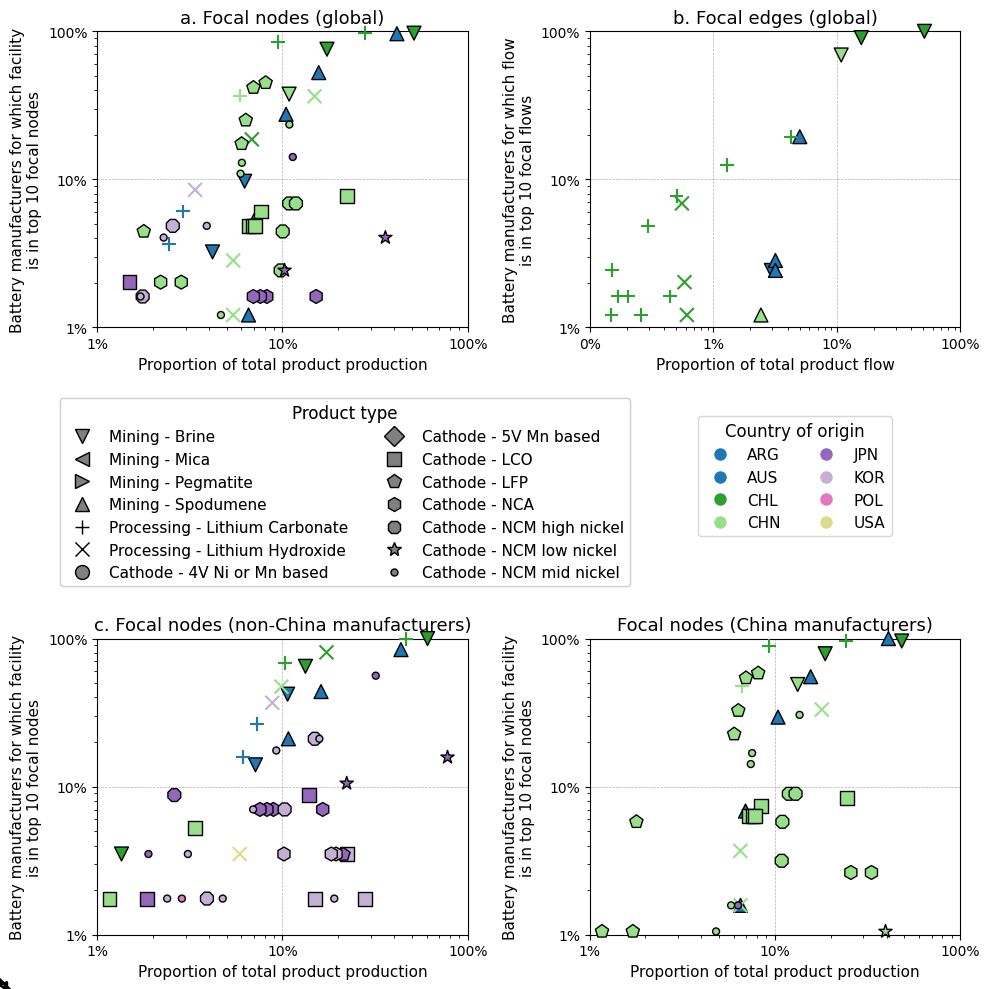

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# -------------------------------
# 2) Set up marker mapping for combined types
# -------------------------------
# Extend marker options for up to 14 types
marker_options = ["v", "<", ">", "^", "+", "x", "o", "D", "s", "p", "h", "8", "*", "."]

# Define custom order for supply stages
supply_order = {"Mining": 0, "Processing": 1, "Cathode": 2}

# Extract unique combined types and sort: first by supply stage then alphabetically by node type.
unique_combined_types = sorted(
    node_metrics["combined_type"].unique(),
    key=lambda x: (supply_order.get(x.split(" - ")[0], 99), x.split(" - ")[1]),
)

# Map each combined type to a marker symbol
marker_mapping = {
    ctype: marker_options[i % len(marker_options)]
    for i, ctype in enumerate(unique_combined_types)
}

# -------------------------------
# 3) Reuse your country-to-colour mapping (assumes 'Country' column in df)
# -------------------------------
all_upstream_countries = sorted(df["Country"].dropna().unique())
# colors = plt.cm.get_cmap('tab20', len(all_upstream_countries))
# country_to_color = {country: colors(i) for i, country in enumerate(all_upstream_countries)}

# -------------------------------
# 4) Create the scatter plots for nodes and edges
# -------------------------------
fig = plt.figure(figsize=(10, 10))

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[2, 1.3, 2])


axs = [
    fig.add_subplot(i)
    for i in [gs[0, 0], gs[0, 1], gs[1, 0], gs[1, 1], gs[2, 0], gs[2, 1]]
]

xlim, ylim = 1, 1
used_nodes = node_metrics[node_metrics["perc_top10"] > ylim]
used_nodes = used_nodes[used_nodes["perc_flow"] > xlim]

# First subplot: nodes
ax = axs[0]
for ctype in unique_combined_types:
    subset = used_nodes[used_nodes["combined_type"] == ctype]
    ax.scatter(
        subset["perc_flow"],
        subset["perc_top10"],
        marker=marker_mapping[ctype],
        c=[country_to_color[c] for c in subset["Country"]],
        edgecolor="black",
        s=100,
        label=ctype,
        clip_on=False,
        zorder=5,
    )
ax.set_xlabel("Proportion of total product production", fontsize=fontsize)
ax.set_ylabel(
    "Battery manufacturers for which facility\nis in top 10 focal nodes",
    fontsize=fontsize,
)
ax.set_title("a. Focal nodes (global)", fontsize=fontsize + 2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, linestyle="--", linewidth=0.5)
ax.set_xlim(xlim, 100)
ax.set_ylim(ylim, 100)
ax.set_axisbelow(True)
formatter = FuncFormatter(lambda x, pos: f"{int(x)}%")
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Second subplot: edges
used_edges = edge_metrics[edge_metrics["perc_top10"] > ylim]
xlim = 0.1
used_edges = used_edges[used_edges["perc_flow"] > xlim]

ax = axs[1]
for ctype in unique_combined_types:
    subset = used_edges[used_edges["combined_type"] == ctype]
    ax.scatter(
        subset["perc_flow"],
        subset["perc_top10"],
        marker=marker_mapping[ctype],
        c=[country_to_color[c] for c in subset["Country"]],
        edgecolor="black",
        s=100,
        label=ctype,
        clip_on=False,
        zorder=5,
    )
ax.set_xlabel("Proportion of total product flow", fontsize=fontsize)
ax.set_ylabel(
    "Battery manufacturers for which flow\nis in top 10 focal flows", fontsize=fontsize
)
ax.set_title("b. Focal edges (global)", fontsize=fontsize + 2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, linestyle="--", linewidth=0.5)
ax.set_xlim(xlim, 100)
ax.set_ylim(ylim, 100)
ax.set_axisbelow(True)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)


# Outside of China nodes
xlim, ylim = 1, 1
used_nodes_nc = node_metrics_nc[node_metrics_nc["perc_top10"] > ylim]
used_nodes_nc = used_nodes_nc[used_nodes_nc["perc_flow"] > xlim]
used_nodes_legend = used_nodes_nc.copy()

# First subplot: nodes
ax = axs[4]
for ctype in unique_combined_types:
    subset = used_nodes_nc[used_nodes_nc["combined_type"] == ctype]
    ax.scatter(
        subset["perc_flow"],
        subset["perc_top10"],
        marker=marker_mapping[ctype],
        c=[country_to_color[c] for c in subset["Country"]],
        edgecolor="black",
        s=100,
        label=ctype,
        clip_on=False,
        zorder=5,
    )
ax.set_xlabel("Proportion of total product production", fontsize=fontsize)
ax.set_ylabel(
    "Battery manufacturers for which facility\nis in top 10 focal nodes",
    fontsize=fontsize,
)
ax.set_title("c. Focal nodes (non-China manufacturers)", fontsize=fontsize + 2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, linestyle="--", linewidth=0.5)
ax.set_xlim(xlim, 100)
ax.set_ylim(ylim, 100)
ax.set_axisbelow(True)
formatter = FuncFormatter(lambda x, pos: f"{int(x)}%")
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Inside of China nodes
xlim, ylim = 1, 1
used_nodes_chn = node_metrics_chn[node_metrics_chn["perc_top10"] > ylim]
used_nodes_chn = used_nodes_chn[used_nodes_chn["perc_flow"] > xlim]

# First subplot: nodes
ax = axs[5]
for ctype in unique_combined_types:
    subset = used_nodes_chn[used_nodes_chn["combined_type"] == ctype]
    ax.scatter(
        subset["perc_flow"],
        subset["perc_top10"],
        marker=marker_mapping[ctype],
        c=[country_to_color[c] for c in subset["Country"]],
        edgecolor="black",
        s=100,
        label=ctype,
        clip_on=False,
        zorder=5,
    )
ax.set_xlabel("Proportion of total product production", fontsize=fontsize)
ax.set_ylabel(
    "Battery manufacturers for which facility\nis in top 10 focal nodes",
    fontsize=fontsize,
)
ax.set_title("Focal nodes (China manufacturers)", fontsize=fontsize + 2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, linestyle="--", linewidth=0.5)
ax.set_xlim(xlim, 100)
ax.set_ylim(ylim, 100)
ax.set_axisbelow(True)
formatter = FuncFormatter(lambda x, pos: f"{int(x)}%")
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)


axs[2].set_visible(False)
axs[3].set_visible(False)

# -------------------------------
# 7) Create combined legends at the bottom of the figure.
# -------------------------------
# Create marker legend handles (Supply Stage - Node/Edge Type)
marker_legend_handles = [
    Line2D(
        [0],
        [0],
        marker=marker_mapping[ctype],
        color="w",
        markerfacecolor="gray",
        markeredgecolor="black",
        markersize=10,
        label=ctype,
    )
    for ctype in unique_combined_types
]

# Create country legend handles (using circles with the assigned colours)
country_legend_handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=country_to_color[c],
        markersize=10,
        label=c,
    )
    for c in sorted(
        [
            i
            for i in country_to_color.keys()
            if i in list(used_nodes_legend["Country"].unique())
        ]
    )
]

# Place the marker legend spanning the bottom, e.g. 8 columns.
marker_legend = fig.legend(
    handles=marker_legend_handles,
    title="Product type",
    title_fontsize=fontsize + 1,
    fontsize=fontsize,
    loc="lower center",
    bbox_to_anchor=(0.35, 0.4),
    ncol=2,
)

# Add the marker legend as an artist, then add the country legend below it.
fig.add_artist(marker_legend)

country_legend = fig.legend(
    handles=country_legend_handles,
    title="Country of origin",
    title_fontsize=fontsize + 1,
    fontsize=fontsize,
    loc="lower center",
    bbox_to_anchor=(0.8, 0.45),
    ncol=2,
)

# white_box = patches.Rectangle((-0.5, -0.50), 0.5, 0.1,
#                               transform=fig.transFigure,
#                               facecolor='white',
#                               edgecolor='none',
#                               zorder=20)
# fig.patches.append(white_box)

plt.tight_layout()
plt.show()

In [27]:
# Save output plot
output_path = "/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/Research_papers/CCG/P3c_lithium_supply_chains/figures/"
filename = "result_Node-edge_importance"
fig.savefig(output_path + filename + ".png", bbox_inches="tight", dpi=300)
fig.savefig(output_path + filename + ".eps", format="eps", bbox_inches="tight", dpi=300)
fig.savefig(output_path + filename + ".pdf", format="pdf", bbox_inches="tight", dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\lukecullen\\Library\\CloudStorage\\OneDrive-UniversityofCambridge\\Research_papers\\CCG\\P3c_lithium_supply_chains\\figures\\result_Node-edge_importance.png'

In [ ]:
nc_count = (
    used_nodes_nc.groupby("Country").count().reset_index()[["Country", "Node ID"]]
)
nc_count["perc"] = (nc_count["Node ID"] / len(used_nodes_nc)) * 100
nc_count

,Country,Node ID,perc
0,ARG,4,8.510638
1,AUS,3,6.382979
2,CHL,6,12.765957
3,CHN,3,6.382979
4,JPN,12,25.531915
5,KOR,17,36.170213
6,POL,1,2.127660
7,USA,1,2.127660


In [ ]:
chn_count = (
    used_nodes_chn.groupby("Country").count().reset_index()[["Country", "Node ID"]]
)
chn_count["perc"] = (chn_count["Node ID"] / len(used_nodes_chn)) * 100
chn_count

,Country,Node ID,perc
0,AUS,5,12.820513
1,CHL,4,10.256410
2,CHN,29,74.358974
3,JPN,1,2.564103


In [ ]:
nodes_df[nodes_df["stage"] == "battery"][
    ["node_id", "name", "company", "Country", "2023"]
].groupby("Country").count()

,node_id,name,company,2023
Country,,,,
CHN,190,190,190,190
CZE,1,1,1,1
DEU,2,2,2,2
FRA,2,2,2,2
GBR,1,1,1,1
HUN,3,3,3,3
JPN,23,23,23,23
KOR,6,6,6,6
MYS,1,1,1,1


In [ ]:
190 / 247

0.7692307692307693

In [ ]:
# Convert the DataFrame to LaTeX table format
latex_nodes = (
    used_nodes[
        [
            "Node ID",
            "Country",
            "Supply stage",
            "Type",
            "perc_top10",
            "total_flow",
            "perc_flow",
        ]
    ]
    .rename(
        columns={
            "Type": "Product",
            "total_flow": "Product mass (t)",
            "perc_flow": "Product mass (%)",
            "perc_top10": "Top 10 (%)",
        }
    )
    .sort_values("Top 10 (%)", ascending=False)
    .to_latex(float_format=lambda x: f"{x:,.0f}", index=False)
)

# Save the LaTeX table to a text file
with open(
    "/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/Post-doc/P3c/outputs/nodes_table_global.tex",
    "w",
) as file:
    file.write(latex_nodes)

In [ ]:
# Convert the DataFrame to LaTeX table format
latex_edges = (
    used_edges[
        [
            "Node ID",
            "Country",
            "target",
            "country_target",
            "Type",
            "perc_top10",
            "total_flow",
            "perc_flow",
        ]
    ]
    .rename(
        columns={
            "Node ID": "Source ID",
            "Country": "Source country",
            "target": "Target ID",
            "country_target": "Target country",
            "Type": "Product",
            "total_flow": "Product mass (t)",
            "perc_flow": "Product mass (%)",
            "perc_top10": "Top 10 (%)",
        }
    )
    .sort_values("Top 10 (%)", ascending=False)
    .to_latex(float_format=lambda x: f"{x:,.0f}", index=False)
)

# Save the LaTeX table to a text file
with open(
    "/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/Post-doc/P3c/outputs/edges_table_global.tex",
    "w",
) as file:
    file.write(latex_edges)

In [ ]:
# Convert the DataFrame to LaTeX table format
latex_nodes = (
    used_nodes_nc[
        [
            "Node ID",
            "Country",
            "Supply stage",
            "Type",
            "perc_top10",
            "total_flow",
            "perc_flow",
        ]
    ]
    .rename(
        columns={
            "Type": "Product",
            "total_flow": "Product mass (t)",
            "perc_flow": "Product mass (%)",
            "perc_top10": "Top 10 (%)",
        }
    )
    .sort_values("Top 10 (%)", ascending=False)
    .to_latex(float_format=lambda x: f"{x:,.0f}", index=False)
)

# Save the LaTeX table to a text file
with open(
    "/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/Post-doc/P3c/outputs/nodes_table_nc.tex",
    "w",
) as file:
    file.write(latex_nodes)

In [ ]:
# Convert the DataFrame to LaTeX table format
latex_nodes = (
    used_nodes_chn[
        [
            "Node ID",
            "Country",
            "Supply stage",
            "Type",
            "perc_top10",
            "total_flow",
            "perc_flow",
        ]
    ]
    .rename(
        columns={
            "Type": "Product",
            "total_flow": "Product mass (t)",
            "perc_flow": "Product mass (%)",
            "perc_top10": "Top 10 (%)",
        }
    )
    .sort_values("Top 10 (%)", ascending=False)
    .to_latex(float_format=lambda x: f"{x:,.0f}", index=False)
)

# Save the LaTeX table to a text file
with open(
    "/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/Post-doc/P3c/outputs/nodes_table_chn.tex",
    "w",
) as file:
    file.write(latex_nodes)

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_24331/1257685180.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_24331/1257685180.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_24331/1257685180.py:77: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_24331/1257685180.py:77: UserWarning: You passed a edgecolor/edgecolors 

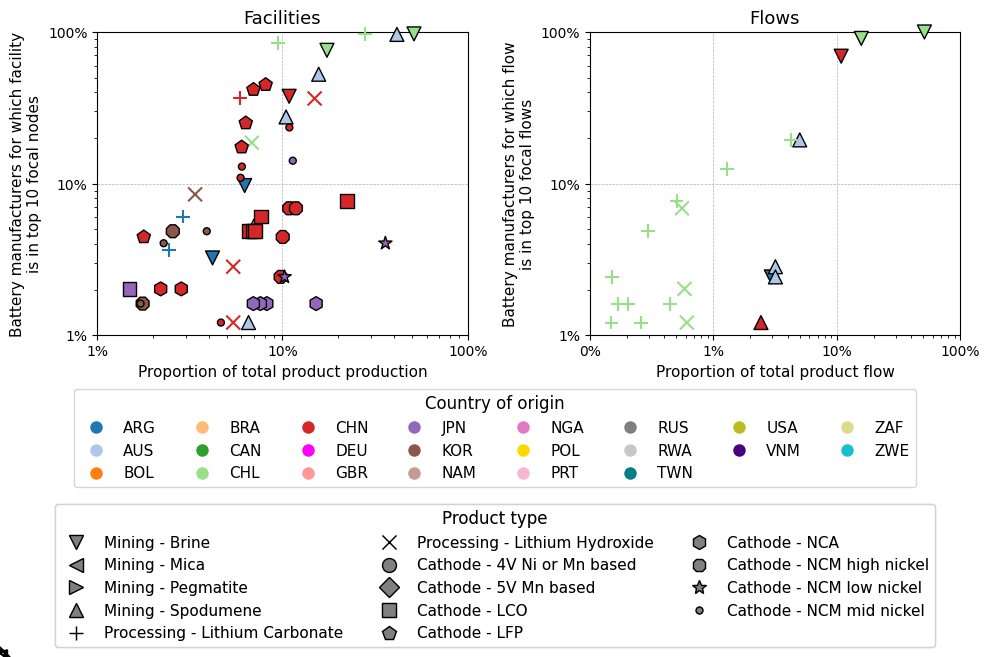

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.lines import Line2D
# from matplotlib.ticker import FuncFormatter
#
# # -------------------------------
# # 2) Set up marker mapping for combined types
# # -------------------------------
# # Extend marker options for up to 14 types
# marker_options = ['v', '<', '>', '^', '+', 'x', 'o', 'D', 's', 'p', 'h', '8', '*', '.']
#
# # Define custom order for supply stages
# supply_order = {"Mining": 0, "Processing": 1, "Cathode": 2}
#
# # Extract unique combined types and sort: first by supply stage then alphabetically by node type.
# unique_combined_types = sorted(
#     node_metrics['combined_type'].unique(),
#     key=lambda x: (supply_order.get(x.split(" - ")[0], 99), x.split(" - ")[1])
# )
#
# # Map each combined type to a marker symbol
# marker_mapping = {ctype: marker_options[i % len(marker_options)] for i, ctype in enumerate(unique_combined_types)}
#
# # -------------------------------
# # 3) Reuse your country-to-colour mapping (assumes 'Country' column in df)
# # -------------------------------
# all_upstream_countries = sorted(df["Country"].dropna().unique())
# # colors = plt.cm.get_cmap('tab20', len(all_upstream_countries))
# # country_to_color = {country: colors(i) for i, country in enumerate(all_upstream_countries)}
#
# # -------------------------------
# # 4) Create the scatter plots for nodes and edges
# # -------------------------------
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
#
# xlim, ylim = 1, 1
# used_nodes = node_metrics[node_metrics['perc_top10'] > ylim]
# used_nodes = used_nodes[used_nodes['perc_flow'] > xlim]
#
# # First subplot: nodes
# ax = axs[0]
# for ctype in unique_combined_types:
#     subset = used_nodes[used_nodes['combined_type'] == ctype]
#     ax.scatter(
#         subset['perc_flow'],
#         subset['perc_top10'],
#         marker=marker_mapping[ctype],
#         c=[country_to_color[c] for c in subset['Country']],
#         edgecolor='black',
#         s=100,
#         label=ctype,
#         clip_on=False,
#         zorder=5
#     )
# ax.set_xlabel("Proportion of total product production", fontsize=fontsize)
# ax.set_ylabel("Battery manufacturers for which facility\nis in top 10 focal nodes", fontsize=fontsize)
# ax.set_title("Facilities", fontsize=fontsize+2)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.grid(True, linestyle='--', linewidth=0.5)
# ax.set_xlim(xlim, 100)
# ax.set_ylim(ylim, 100)
# ax.set_axisbelow(True)
# formatter = FuncFormatter(lambda x, pos: f"{int(x)}%")
# ax.xaxis.set_major_formatter(formatter)
# ax.yaxis.set_major_formatter(formatter)
#
# # Second subplot: edges
# used_edges = edge_metrics[edge_metrics['perc_top10'] > ylim]
# xlim = 0.1
# used_edges = used_edges[used_edges['perc_flow'] > xlim]
#
# ax = axs[1]
# for ctype in unique_combined_types:
#     subset = used_edges[used_edges['combined_type'] == ctype]
#     ax.scatter(
#         subset['perc_flow'],
#         subset['perc_top10'],
#         marker=marker_mapping[ctype],
#         c=[country_to_color[c] for c in subset['Country']],
#         edgecolor='black',
#         s=100,
#         label=ctype,
#         clip_on=False,
#         zorder=5
#     )
# ax.set_xlabel("Proportion of total product flow", fontsize=fontsize)
# ax.set_ylabel("Battery manufacturers for which flow\nis in top 10 focal flows", fontsize=fontsize)
# ax.set_title("Flows", fontsize=fontsize+2)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.grid(True, linestyle='--', linewidth=0.5)
# ax.set_xlim(xlim, 100)
# ax.set_ylim(ylim, 100)
# ax.set_axisbelow(True)
# ax.xaxis.set_major_formatter(formatter)
# ax.yaxis.set_major_formatter(formatter)
#
# # -------------------------------
# # 7) Create combined legends at the bottom of the figure.
# # -------------------------------
# # Create marker legend handles (Supply Stage - Node/Edge Type)
# marker_legend_handles = [Line2D([0], [0],
#                                 marker=marker_mapping[ctype],
#                                 color='w',
#                                 markerfacecolor='gray',
#                                 markeredgecolor='black',
#                                 markersize=10,
#                                 label=ctype)
#                          for ctype in unique_combined_types]
#
# # Create country legend handles (using circles with the assigned colours)
# country_legend_handles = [Line2D([0], [0],
#                                  marker='o',
#                                  color='w',
#                                  markerfacecolor=country_to_color[c],
#                                  markersize=10,
#                                  label=c)
#                           for c in sorted(country_to_color.keys())]
#
# # Place the marker legend spanning the bottom, e.g. 8 columns.
# marker_legend = fig.legend(handles=marker_legend_handles,
#                            title="Product type",
#                            title_fontsize=fontsize+1,
#                            fontsize=fontsize,
#                            loc='lower center',
#                            bbox_to_anchor=(0.5, -0.65),
#                            ncol=3)
#
# # Add the marker legend as an artist, then add the country legend below it.
# fig.add_artist(marker_legend)
#
# country_legend = fig.legend(handles=country_legend_handles,
#                             title="Country of origin",
#                             title_fontsize=fontsize+1,
#                             fontsize=fontsize,
#                             loc='lower center',
#                             bbox_to_anchor=(0.5, -0.25),
#                             ncol=8)
#
# # white_box = patches.Rectangle((-0.5, -0.50), 0.5, 0.1,
# #                               transform=fig.transFigure,
# #                               facecolor='white',
# #                               edgecolor='none',
# #                               zorder=20)
# # fig.patches.append(white_box)
#
# plt.tight_layout()
# plt.show()